In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housedata/output.csv
/kaggle/input/housedata/data.csv
/kaggle/input/housedata/data.dat


# 1. Load Libraries and Import Data

In [2]:
# Basic
import numpy as np
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from missingno import matrix
from sklearn.pipeline import Pipeline

# Models
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

# Hyperparameter Tuning
import optuna
from sklearn.model_selection import cross_val_score


# Evaluation
from xgboost import plot_importance
import shap
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, f1_score, average_precision_score, r2_score
from sklearn.inspection import permutation_importance



from sklearn.ensemble import RandomForestRegressor



## Helper Functions


In [3]:
def plot_num_distros(data, numerical_features):
    
    
    # Define number of rows and columns
    n_cols = 5  # Number of columns
    n_rows = -(-len(numerical_features) // n_cols)  # Compute required rows dynamically
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))  # Adjust figure size for better visibility
    axes = axes.flatten()  # Flatten axes array to easily iterate
    
    # Plot histograms for each numerical feature
    for i, feature in enumerate(numerical_features):
        axes[i].hist(data[feature], bins=30, edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Count')
    
    # Remove empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [4]:
def plot_box_whisker(numerical_features, data):
    
    # Define the number of rows and columns for the grid
    num_cols = 4
    num_rows = -(-len(numerical_features) // num_cols)  # Ceiling division
    
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()  # Flatten axes array for easier iteration
    
    for i, feature in enumerate(numerical_features):
        axes[i].boxplot(data[f'{feature}'], vert=False, patch_artist=True, showfliers=True,
                        flierprops=dict(marker='o', color='red'))
        axes[i].set_xlabel(f'{feature}')
        axes[i].set_title(f'Box-and-Whisker Plot of {feature}')
    
    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

In [5]:
# Scatter plot of numerical feature correlations

def plot_scatter_price(data, numerical_features):
    """
    Plots scatter plots of numerical features against price in a grid layout.

    Parameters:
    - data: DataFrame containing the dataset.
    - numerical_features: List of numerical features to plot against price.
    """
    
    # Define number of rows and columns
    n_cols = 3  # Number of columns
    n_rows = -(-len(numerical_features) // n_cols)  # Compute required rows dynamically
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))  # Adjust figure size
    axes = axes.flatten()  # Flatten axes array for easy iteration
    
    # Plot scatter plots for each numerical feature vs. price
    for i, feature in enumerate(numerical_features):
        sns.scatterplot(x=data[feature], y=data['price'], ax=axes[i], alpha=0.5)
        axes[i].set_title(f'{feature} vs Price')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Price')

    # Remove empty subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [6]:
import pandas as pd
import numpy as np

def extract_results(model_object, param_grid):
    """
    Extracts and processes results from a fitted RandomizedSearchCV or GridSearchCV model.

    Args:
        model_object: Fitted RandomizedSearchCV or GridSearchCV object.
        param_grid: Dictionary of hyperparameters used for tuning.

    Returns:
        scores (DataFrame): DataFrame with hyperparameter configurations, training & validation scores, and variance.
    """

    # Extract results from GridSearchCV or RandomizedSearchCV
    results = pd.DataFrame(model_object.cv_results_)

    # Get the hyperparameter names and prepend 'param_'
    hyperparams = ['param_' + param for param in param_grid.keys()]

    # Identify available scoring columns dynamically
    train_col = [col for col in results.columns if 'mean_train_' in col]
    test_col = [col for col in results.columns if 'mean_test_' in col]

    # Determine the primary scoring metric used
    scoring_metric = model_object.refit if isinstance(model_object.refit, str) else test_col[0].replace("mean_test_", "")

    mean_train_col = f'mean_train_{scoring_metric}' if f'mean_train_{scoring_metric}' in train_col else None
    mean_test_col = f'mean_test_{scoring_metric}' if f'mean_test_{scoring_metric}' in test_col else None

    if mean_train_col:
        columns_to_keep = [mean_test_col, mean_train_col] + hyperparams
        scores = results[columns_to_keep].rename(columns={mean_train_col: 'mean_train_score', mean_test_col: 'mean_test_score'})

        # Compute variance (difference between train and validation scores)
        scores['variance'] = scores['mean_train_score'] - scores['mean_test_score']
    else:
        columns_to_keep = [mean_test_col] + hyperparams
        scores = results[columns_to_keep].rename(columns={mean_test_col: 'mean_test_score'})
        scores['variance'] = None  # No training score available

    # ✅ Convert negative scoring metrics to their absolute values (for correct interpretation)
    if scoring_metric.startswith("neg_"):
        scores['mean_train_score'] = -scores['mean_train_score']
        scores['mean_test_score'] = -scores['mean_test_score']
        scores['variance'] = -scores['variance']
        scoring_metric = scoring_metric.replace("neg_", "")  # Update for display purposes

    # ✅ Display best parameters and best score
    best_score = -model_object.best_score_ if model_object.scoring.startswith("neg_") else model_object.best_score_

    print(f"Best {scoring_metric}: {best_score:.4f}")
    print(f"Best parameters: {model_object.best_params_}")

    # ✅ Display the top rows
    print(scores.head(10))

    return scores

In [7]:
class BiasVarianceAnalyzer:
    def __init__(self, search_results, hyperparameters=None, scoring_metric=None, smooth_results=True):
        """
        Initialize the Bias-Variance Analyzer.

        Parameters:
        - search_results: The cv_results_ from GridSearchCV or RandomizedSearchCV.
        - hyperparameters (optional): List of hyperparameters to analyze. If not provided, it detects them automatically.
        - scoring_metric: The metric to analyze (e.g., 'accuracy', 'f1', 'neg_mean_squared_error'). 
                          Defaults to the model's scoring.
        - smooth_results: Whether to smooth results by averaging duplicate hyperparameter sets.
        """
        self.results = pd.DataFrame(search_results.cv_results_)
        self.scoring_metric = scoring_metric if scoring_metric else search_results.scoring
        self.smooth_results = smooth_results
        self.scores = None

        # ✅ Handle negative scoring metrics (flip sign)
        self.negative_metric = self.scoring_metric.startswith("neg_")
        if self.negative_metric:
            self.scoring_metric = self.scoring_metric.replace("neg_", "")  # Remove "neg_" prefix for clarity

        # ✅ Automatically detect hyperparameters if not provided
        if hyperparameters is None:
            self.hyperparameters = [
                col.replace("param_", "") for col in self.results.columns if col.startswith("param_")
            ]
        else:
            self.hyperparameters = hyperparameters

    def extract_scores(self):
        """ Extract relevant scores and hyperparameter values from the search results. """
        hyperparam_columns = [f'param_{param}' for param in self.hyperparameters]
        columns_to_keep = ['mean_test_score', 'mean_train_score'] + hyperparam_columns

        # Extract scores and hyperparameters
        self.scores = self.results[columns_to_keep].copy()

        # ✅ Convert hyperparameters to numeric if possible
        for col in hyperparam_columns:
            self.scores[col] = pd.to_numeric(self.scores[col], errors='ignore')

        # ✅ Rename columns back to user-provided hyperparameter names (for easy access)
        rename_dict = {col: col.replace('param_', '') for col in hyperparam_columns}
        self.scores.rename(columns=rename_dict, inplace=True)

        # ✅ Flip signs for negative metrics (ensure proper RMSE/MSE interpretation)
        if self.negative_metric:
            self.scores['mean_train_score'] = -self.scores['mean_train_score']
            self.scores['mean_test_score'] = -self.scores['mean_test_score']

        # ✅ Compute variance (bias-variance tradeoff)
        self.scores['variance'] = self.scores['mean_train_score'] - self.scores['mean_test_score']

        # ✅ Smooth results by averaging duplicate hyperparameter configurations
        if self.smooth_results:
            self.scores = self.scores.groupby(self.hyperparameters).mean().reset_index()

        return self.scores

    def plot_bias_variance(self):
        """ Generate bias-variance plots for hyperparameters. """
        if self.scores is None:
            self.extract_scores()
    
        num_hyperparams = len(self.hyperparameters)
    
        if num_hyperparams == 0:
            print("⚠️ No hyperparameters found for bias-variance analysis.")
            return
    
        elif num_hyperparams == 1:
            # ✅ Special case: Only one hyperparameter, directly plot it
            hyperparam = self.hyperparameters[0]
    
            # Ensure hyperparameter values are numeric
            if not np.issubdtype(self.scores[hyperparam].dtype, np.number):
                print(f"⚠️ Converting {hyperparam} to numeric.")
                self.scores[hyperparam] = pd.to_numeric(self.scores[hyperparam], errors='coerce')
    
            if self.scores[hyperparam].notna().all():  # Check if conversion was successful
                self.scores = self.scores.sort_values(by=hyperparam)
    
                plt.figure(figsize=(8, 5))
    
                # ✅ Scatter plot instead of line plot to reflect actual values used
                plt.scatter(self.scores[hyperparam], self.scores['mean_train_score'], label='Train Score', marker='o', color='blue')
                plt.scatter(self.scores[hyperparam], self.scores['mean_test_score'], label='Validation Score', marker='o', color='orange')
    
                # ✅ Connect points with a dashed line
                plt.plot(self.scores[hyperparam], self.scores['mean_train_score'], linestyle='-', alpha=0.7, color='blue')
                plt.plot(self.scores[hyperparam], self.scores['mean_test_score'], linestyle='--', alpha=0.7, color='orange')
    
                plt.xlabel(hyperparam)
                plt.ylabel(f'{self.scoring_metric} Score')
                plt.title(f'Bias-Variance Analysis for {hyperparam}')
                plt.legend()
                plt.grid(True)
    
                # ✅ Use log-scale for better visualization if hyperparameter spans orders of magnitude
                if self.scores[hyperparam].min() > 0 and self.scores[hyperparam].max() / self.scores[hyperparam].min() > 10:
                    plt.xscale('log')
    
                plt.show()
            else:
                print(f"⚠️ {hyperparam} could not be converted to numeric.")

    def analyze(self):
        """ Run bias-variance analysis and generate insights. """
        self.extract_scores()
        self.plot_bias_variance()

        # Identify best-performing hyperparameter set
        best_row = self.scores.loc[self.scores['mean_test_score'].idxmax()]
        print("\n🔹 **Best Hyperparameter Configuration (Based on Validation Score)** 🔹")
        print(best_row.to_string())

        return self.scores

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class FeatureImportanceAnalyzer:
    """
    A class for analyzing and visualizing feature importance for Ridge, Lasso, and Linear Regression models.

    Methods:
    - extract_feature_importance(): Returns a DataFrame with feature importance values.
    - plot_feature_importance(top_n=10): Plots the top N most important features.
    """

    def __init__(self, model, feature_names, target_transformation=None, feature_scaler=None, target_average=None):
        """
        Initialize the FeatureImportanceAnalyzer.

        Args:
            model: A trained LinearRegression, Ridge, or Lasso model.
            feature_names: List of feature names after preprocessing.
            target_transformation: If "log", reverse log transformation.
            feature_scaler: The scaler (e.g., StandardScaler) used for numeric features.
        """
        self.model = model
        self.feature_names = feature_names
        self.target_transformation = target_transformation
        self.feature_scaler = feature_scaler
        self.importance_df = None
        self.target_average = target_average

    def extract_feature_importance(self):
        """
        Extracts and sorts feature importance from the model.

        Returns:
            A DataFrame with features and their importance scores.
        """
        if not hasattr(self.model, "coef_"):
            raise ValueError("Model does not have a coef_ attribute. Ensure it is a linear model.")

        coef = self.model.coef_

        # Handle multi-output models
        if coef.ndim > 1:
            coef = coef.flatten()

        # ✅ Ensure correct mapping between coefficients and feature names
        if len(coef) != len(self.feature_names):
            raise ValueError(f"Mismatch between feature names ({len(self.feature_names)}) and model coefficients ({len(coef)}).")

        # ✅ Reverse scaling if features were standardized
        if self.feature_scaler is not None:
            if hasattr(self.feature_scaler, "scale_"):  # StandardScaler, MinMaxScaler
                num_scaled = len(self.feature_scaler.scale_)
                coef[:num_scaled] /= self.feature_scaler.scale_  # Convert back to original scale
            else:
                print("⚠️ Feature scaler provided, but no `scale_` attribute found. Skipping rescaling.")

        # ✅ Do **NOT** exponentiate coefficients even if target was log-transformed
        #    Coefficients in log-space already represent % change in price per unit increase.
        if self.target_transformation == "log":
            coef *= self.target_average / 100  # Convert to % impact on average of target

        # ✅ Store results
        self.importance_df = pd.DataFrame({'Feature': self.feature_names, 'Importance': coef})
        self.importance_df['Abs_Importance'] = np.abs(self.importance_df['Importance'])  # Absolute value for ranking
        self.importance_df = self.importance_df.sort_values(by='Abs_Importance', ascending=False)

        return self.importance_df

    def plot_feature_importance(self, top_n=10):
        """
        Plots the top N most important features.

        Args:
            top_n: Number of top features to plot.
        """
        if self.importance_df is None:
            self.extract_feature_importance()

        top_features = self.importance_df.head(top_n).sort_values(by="Importance")

        plt.figure(figsize=(8, 6))
        bars = plt.barh(
            top_features["Feature"], 
            top_features["Importance"], 
            color=np.where(top_features["Importance"] > 0, 'blue', 'red')
        )
        plt.xlabel("Coefficient Value")
        plt.ylabel("Feature")
        plt.title(f"Top {top_n} Most Important Features")
        plt.axvline(x=0, color='black', linestyle='--')  # Add zero reference line
        plt.grid(True)
        plt.show()

## 1a. Load Libraries

## 1b. Import Data

In [9]:
data_raw = pd.read_csv("/kaggle/input/housedata/data.csv")  

data = pd.read_csv("/kaggle/input/housedata/data.csv")

# 2. Understand the Data

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

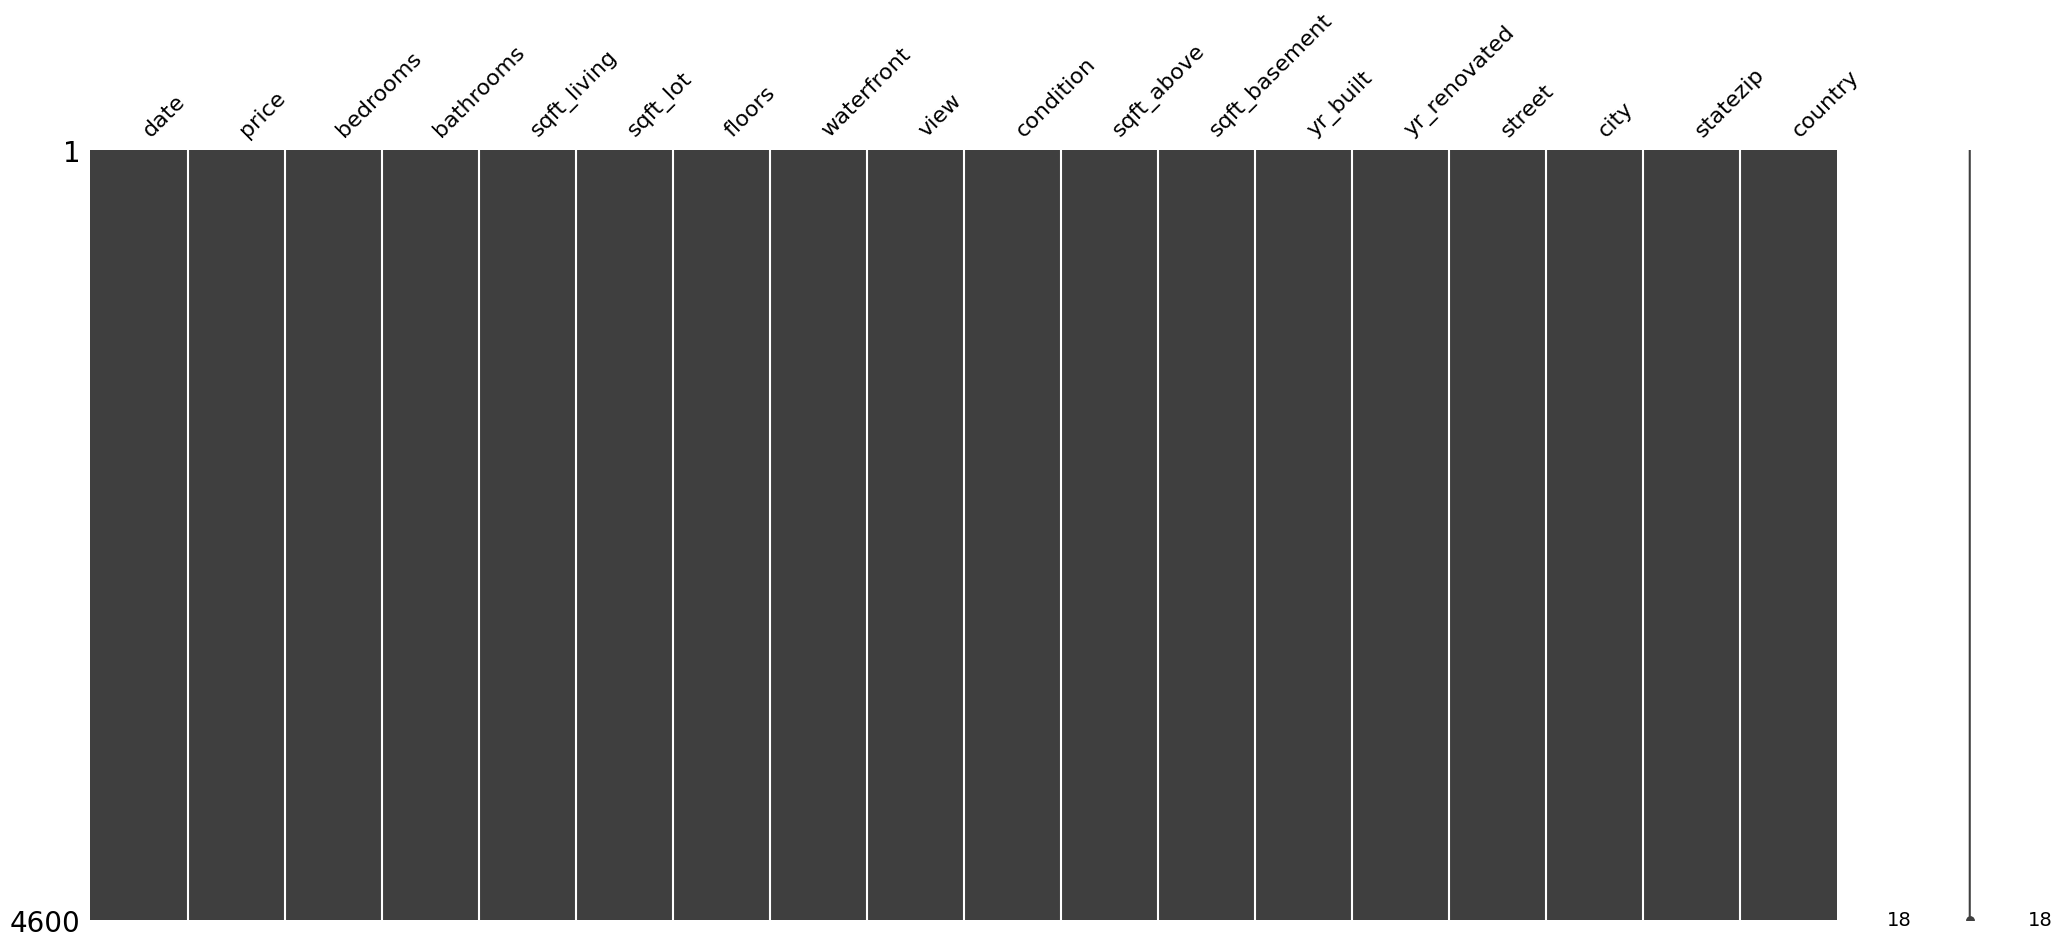

In [10]:
# Check for missing values
matrix(data)
data.isnull().sum()

No missing values

# 3. Exploratory Data Analysis

In [11]:
# Easy way to get numericla and categorical columns

# num_cols = [col for col in house.columns if house[col].dtype in ['float64','int64']]
# cat_cols = [col for col in house.columns if house[col].dtype not in ['float64','int64']]

## 3a. Numerical Variables

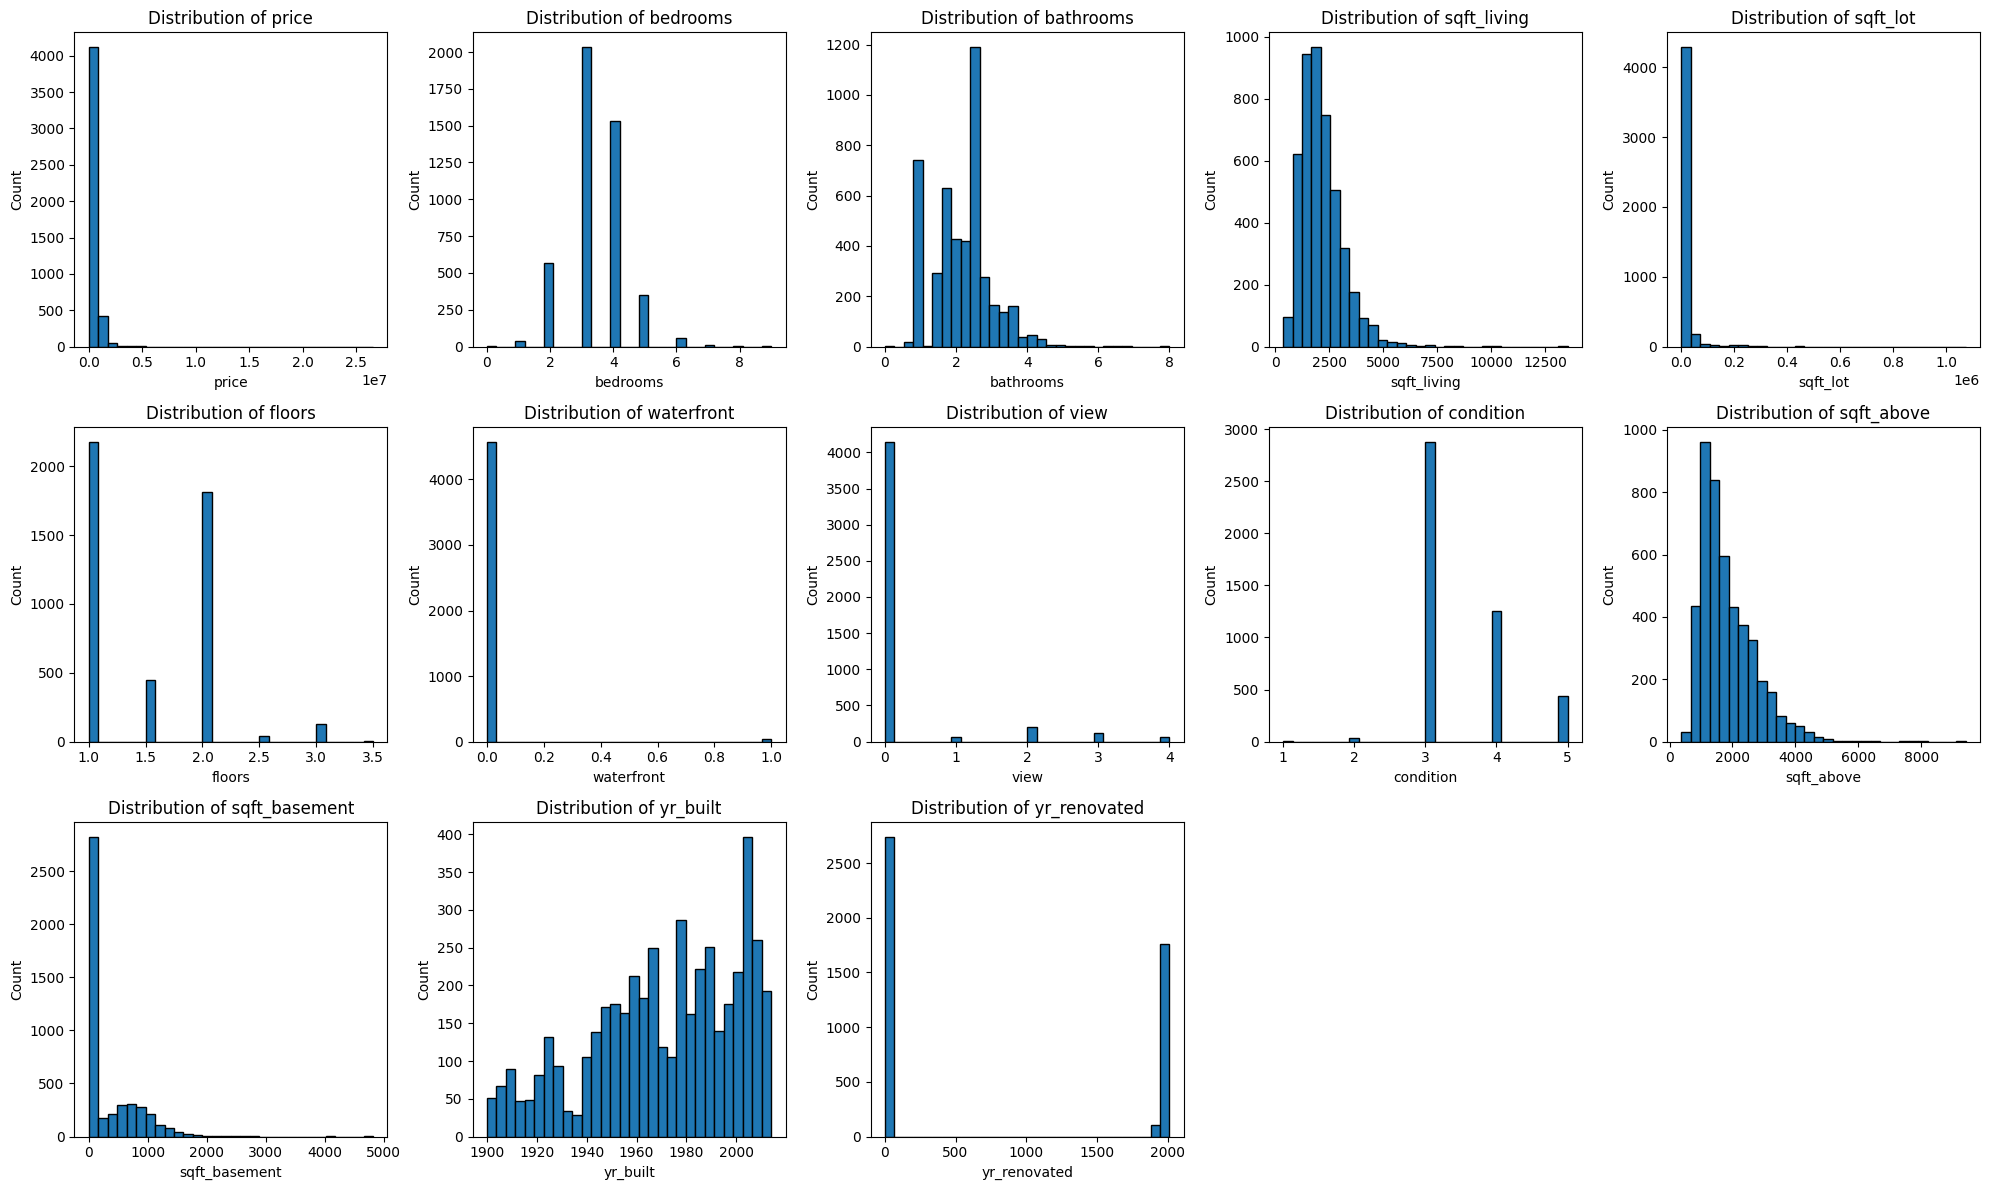

In [12]:
import matplotlib.pyplot as plt

# Define numerical features
numerical_features = [
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
    'floors', 'waterfront', 'view', 'condition', 'sqft_above', 
    'sqft_basement', 'yr_built', 'yr_renovated'
]

plot_num_distros(data, numerical_features)


**Observations:**
1. Remove instances where property sold for $0
2. Remove 'Waterfront' and 'view' as vast majority of properties don't have waterfront
3. Add features:
* age
* reno (binary)
* years_since_reno
* basement (binary)
* sqft_total
4. Remove:
  * yr_built
  * yr_renovated
  * sqft_above
  * sqft_basement

 
5. Apply log transformation to highly skewed variables

In [13]:
# Remove rows with 0 in price since this will not affect the data

data.drop(labels=data[data['price'] == 0].index, axis=0, inplace=True)

In [14]:
# Remove waterfront column

features_to_drop = ['waterfront','view']

data = data.drop(columns=features_to_drop)

for feature in features_to_drop:
    numerical_features.remove(feature)

In [15]:
# Add variables for age and month

# Ensure the column is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract the year
data['year'] = data['date'].dt.year

# Month not necessary because sales are only in May-July
# Add Sine-cosine encodings for months 
# data['month'] = data['date'].dt.month
# data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
# data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Add age column
data['age'] = data['year'] - data['yr_built']

features_to_add = ['age']

for feature in features_to_add:
    numerical_features.append(feature)


print(data.head())

        date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0 2014-05-02   313000.0       3.0       1.50         1340      7912     1.5   
1 2014-05-02  2384000.0       5.0       2.50         3650      9050     2.0   
2 2014-05-02   342000.0       3.0       2.00         1930     11947     1.0   
3 2014-05-02   420000.0       3.0       2.25         2000      8030     1.0   
4 2014-05-02   550000.0       4.0       2.50         1940     10500     1.0   

   condition  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          3        1340              0      1955          2005   
1          5        3370            280      1921             0   
2          4        1930              0      1966             0   
3          4        1000           1000      1963             0   
4          4        1140            800      1976          1992   

                     street       city  statezip country  year  age  
0      18810 Densmore Ave N  Shoreline  WA 98133    

In [16]:
# Add Variable for if renovated and years_since_reno

data['renovated'] = (data['yr_renovated'] != 0).astype(int)
data['years_since_reno'] = np.where(data['renovated'] == 1, data['year'] - data['yr_renovated'], np.nan)


features_to_drop = ['yr_built', 'yr_renovated']

data = data.drop(columns=features_to_drop)
data = data.drop(columns='year')


for feature in features_to_drop:
    numerical_features.remove(feature)

features_to_add = ['years_since_reno']

for feature in features_to_add:
    numerical_features.append(feature)

data.head()

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,street,city,statezip,country,age,renovated,years_since_reno
0,2014-05-02,313000.0,3.0,1.50,1340,7912,1.5,3,1340,0,18810 Densmore Ave N,Shoreline,WA 98133,USA,59,1,9.0
1,2014-05-02,2384000.0,5.0,2.50,3650,9050,2.0,5,3370,280,709 W Blaine St,Seattle,WA 98119,USA,93,0,NaN
2,2014-05-02,342000.0,3.0,2.00,1930,11947,1.0,4,1930,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,48,0,NaN
3,2014-05-02,420000.0,3.0,2.25,2000,8030,1.0,4,1000,1000,857 170th Pl NE,Bellevue,WA 98008,USA,51,0,NaN
4,2014-05-02,550000.0,4.0,2.50,1940,10500,1.0,4,1140,800,9105 170th Ave NE,Redmond,WA 98052,USA,38,1,22.0


In [17]:
# add feature for 'basement'
data['basement'] = (data['sqft_basement'] != 0).astype(int)

data[['sqft_basement','basement']].head()

,sqft_basement,basement
0,0,0
1,280,1
2,0,0
3,1000,1
4,800,1


In [18]:
# Variable for sqft_total

data['sqft_total'] = data['sqft_above'] + data['sqft_basement']


features_to_add = ['sqft_total']

for feature in features_to_add:
    numerical_features.append(feature)

features_to_drop = ['sqft_above', 'sqft_basement']

data = data.drop(columns=features_to_drop)

for feature in features_to_drop:
    numerical_features.remove(feature)



In [19]:
# Check skewness

for feature in numerical_features:
    skewness = skew(data[feature], nan_policy='omit')
    print(f'{feature} skewness: {skewness}')

price skewness: 25.015568709381824
bedrooms skewness: 0.46688494992954227
bathrooms skewness: 0.5864360499340144
sqft_living skewness: 1.7183209475659638
sqft_lot skewness: 11.325280024844504
floors skewness: 0.5521606261462427
condition skewness: 0.964241904769608
age skewness: 0.5058354866733586
years_since_reno skewness: 2.3625163919283465
sqft_total skewness: 1.7183209475659638


In [20]:
log_variables = [
    'price',
    'sqft_living',
    'sqft_lot',
    'sqft_total',
    'years_since_reno'
]

for variable in log_variables:
    data[f'{variable}'] = np.log1p(data[f'{variable}'])

for feature in numerical_features:
    skewness = skew(data[feature], nan_policy='omit')
    print(f'{feature} skewness: {skewness}')

price skewness: 0.32988567323792295
bedrooms skewness: 0.46688494992954227
bathrooms skewness: 0.5864360499340144
sqft_living skewness: -0.05295696331385413
sqft_lot skewness: 0.8416541547161376
floors skewness: 0.5521606261462427
condition skewness: 0.964241904769608
age skewness: 0.5058354866733586
years_since_reno skewness: -0.4762587596178817
sqft_total skewness: -0.05295696331385413


invalid value encountered in log1p


invalid value encountered in greater_equal
invalid value encountered in less_equal


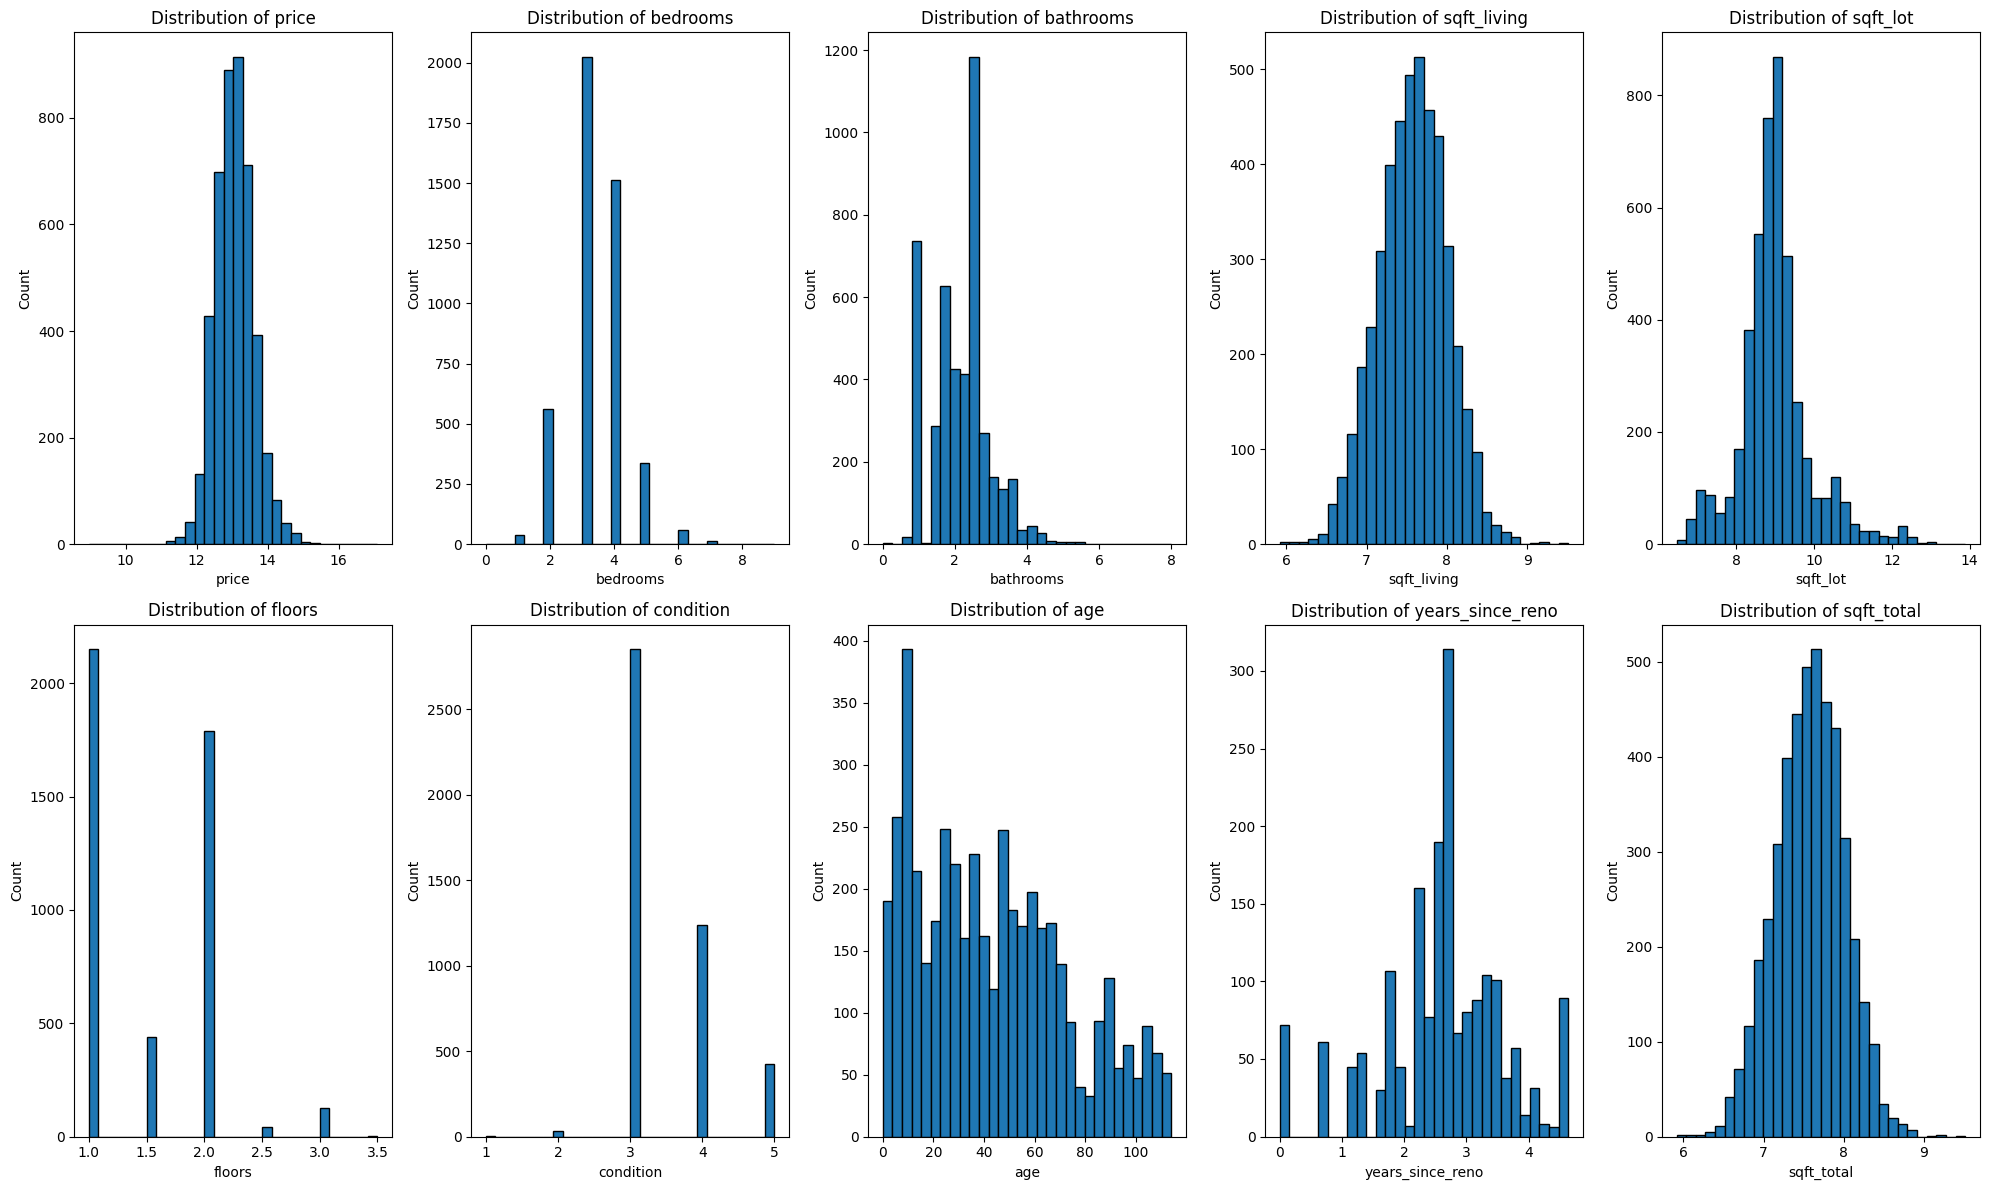

In [21]:
plot_num_distros(data, numerical_features)

invalid value encountered in less_equal
invalid value encountered in greater_equal
invalid value encountered in less
invalid value encountered in greater


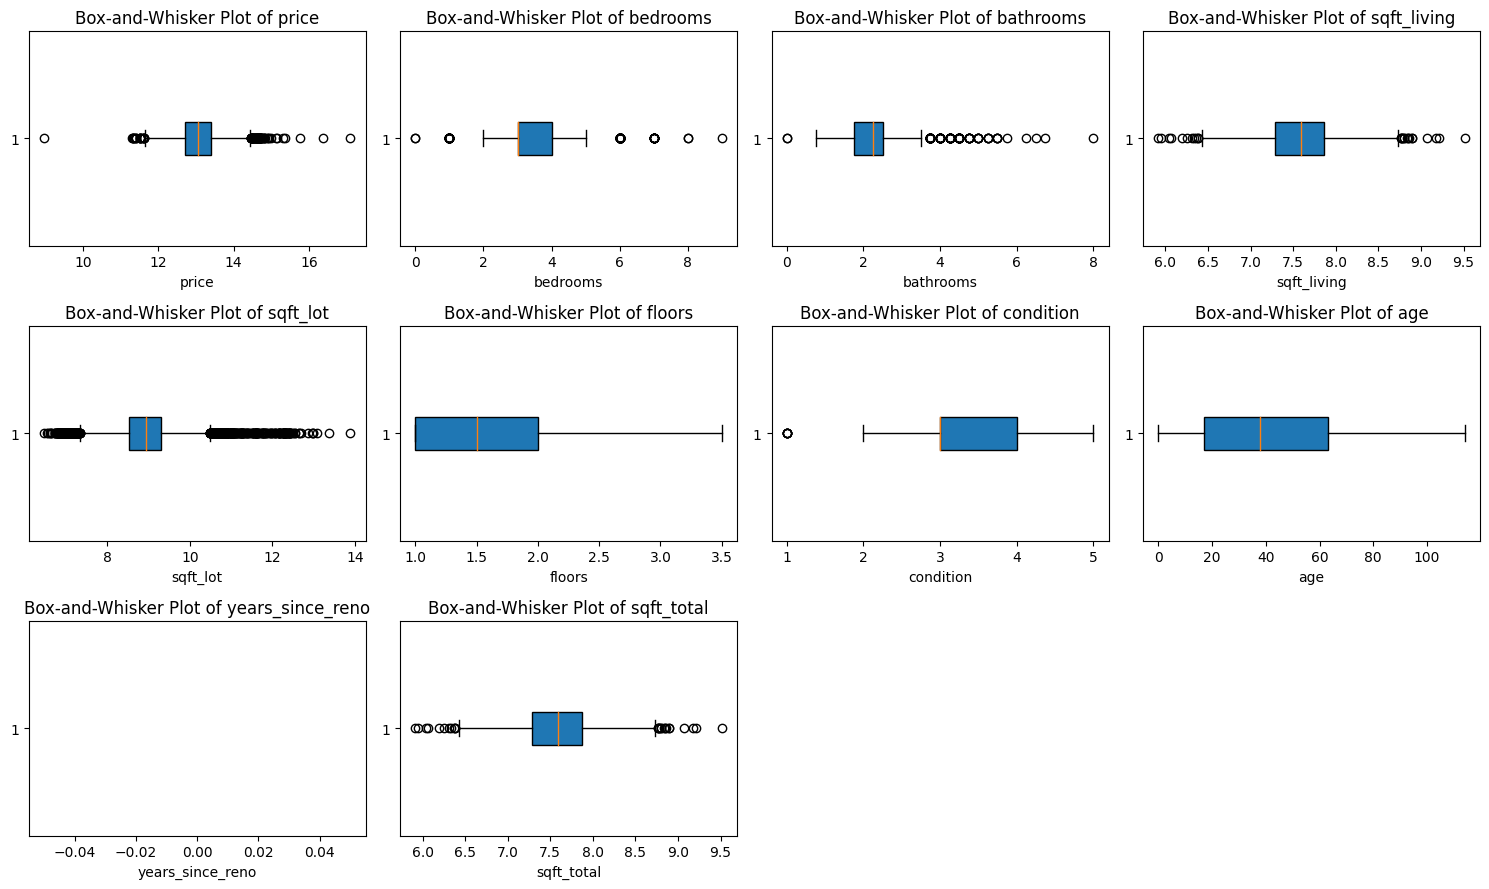

In [22]:
plot_box_whisker(numerical_features, data)

In [23]:
for feature in numerical_features:
    skewness = skew(data[feature], nan_policy='omit')
    print(f'{feature} skewness: {skewness}')

price skewness: 0.32988567323792295
bedrooms skewness: 0.46688494992954227
bathrooms skewness: 0.5864360499340144
sqft_living skewness: -0.05295696331385413
sqft_lot skewness: 0.8416541547161376
floors skewness: 0.5521606261462427
condition skewness: 0.964241904769608
age skewness: 0.5058354866733586
years_since_reno skewness: -0.4762587596178817
sqft_total skewness: -0.05295696331385413


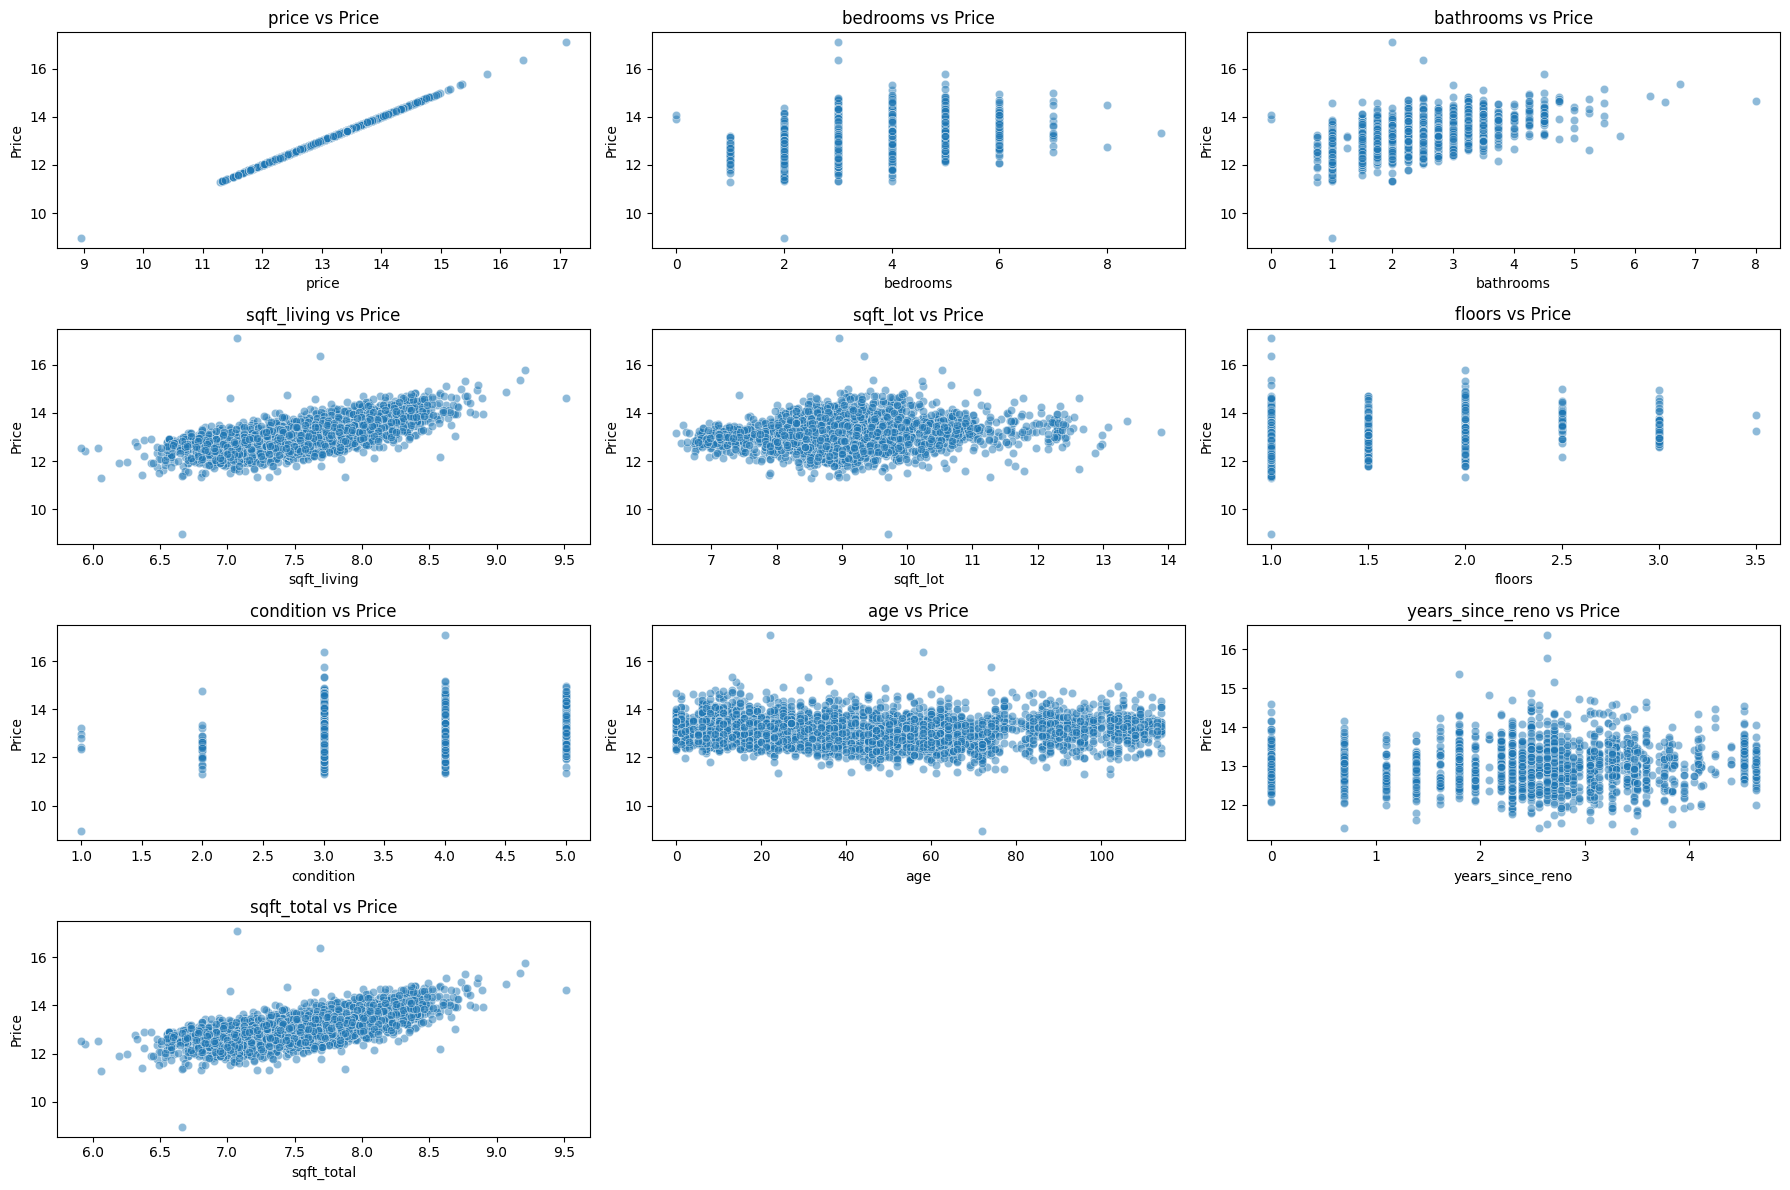

In [24]:
plot_scatter_price(data, numerical_features)

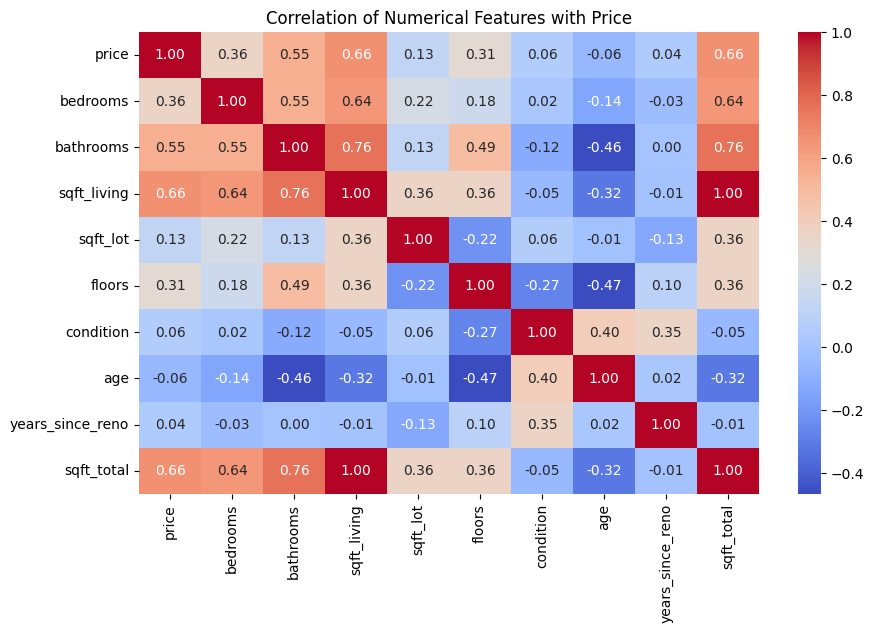

In [25]:
# Compute correlation matrix
corr_matrix = data[numerical_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Numerical Features with Price")
plt.show()

**Observations:**
1. Strong positive:
   - sqft_total
   - sqft_living
   - bathrooms
2. Moderate positive:
   - bedrooms
   - floors
3. Minimal/No correlation:
   - sqft_lot
   - years_since_reno
   - condition
   - age
     

In [26]:
# Remove sqft_living  because already highly correlated with sqft_total
# Remove sqft_lot because weak correlation with price

features_to_drop = ['sqft_living', 'sqft_lot']

data = data.drop(columns=features_to_drop)

for feature in features_to_drop:
    numerical_features.remove(feature)

## 3b. Categorical Variables

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4551 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              4551 non-null   datetime64[ns]
 1   price             4551 non-null   float64       
 2   bedrooms          4551 non-null   float64       
 3   bathrooms         4551 non-null   float64       
 4   floors            4551 non-null   float64       
 5   condition         4551 non-null   int64         
 6   street            4551 non-null   object        
 7   city              4551 non-null   object        
 8   statezip          4551 non-null   object        
 9   country           4551 non-null   object        
 10  age               4551 non-null   int64         
 11  renovated         4551 non-null   int64         
 12  years_since_reno  1845 non-null   float64       
 13  basement          4551 non-null   int64         
 14  sqft_total        4551 non-nu

In [28]:
categorical_features = [
    'renovated',
    'basement'
]

# Count unique values for each categorical feature
unique_counts = data[categorical_features].nunique()

# Display the results
print(unique_counts)

renovated    2
basement     2
dtype: int64


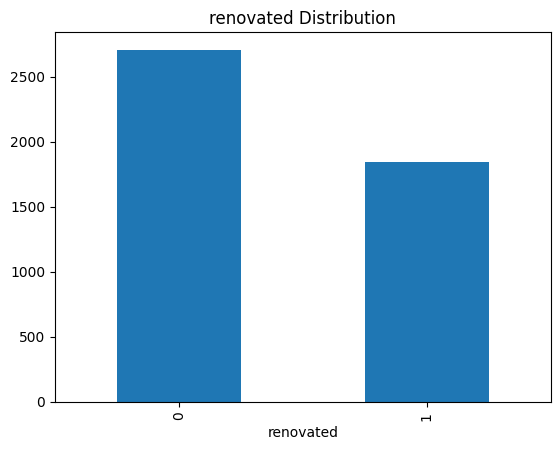

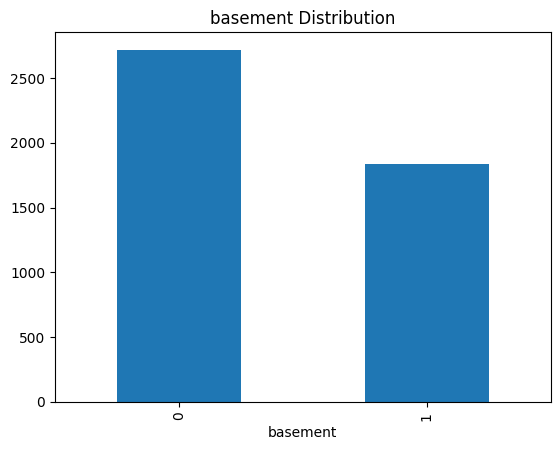

In [29]:
for feature in categorical_features:
    data[f'{feature}'].value_counts().plot(kind='bar')
    plt.title(f'{feature} Distribution')
    plt.show()

More homes without renovation and without basement, but not heavily skewed

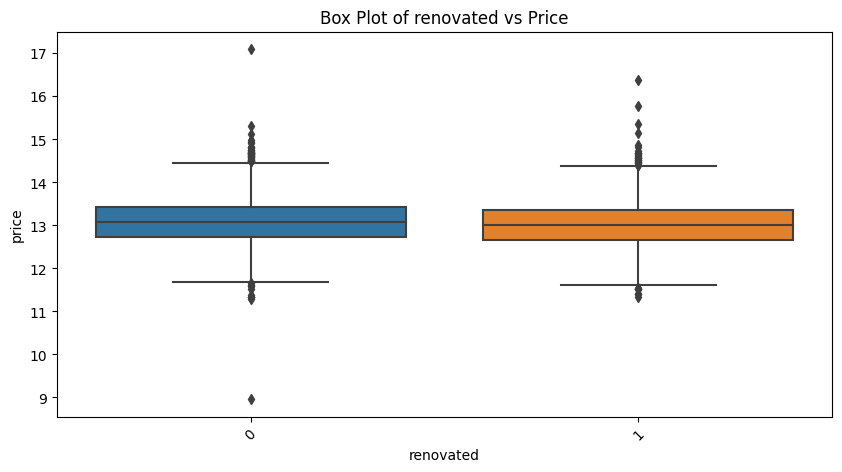

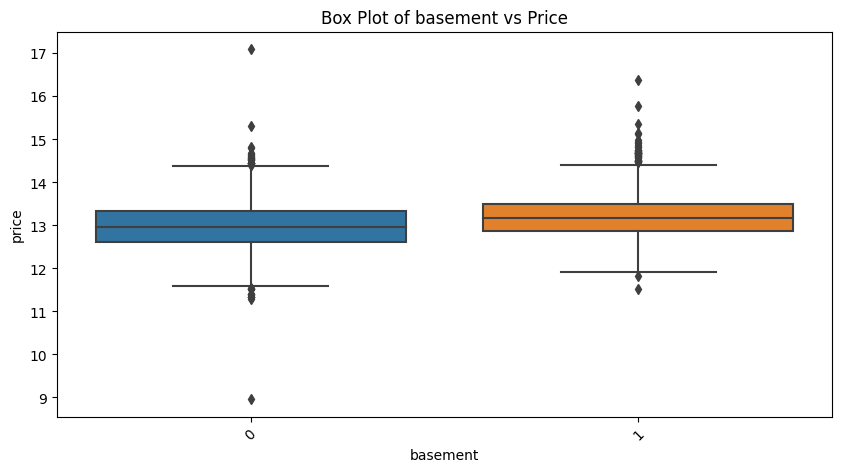

In [30]:
# Create box plots for each categorical feature against price
for feature in categorical_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=data[feature], y=data['price'])
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.title(f'Box Plot of {feature} vs Price')
    plt.show()

Doesn't appear to be overly strong correlation between renovation and price and basement and price.  
If anything, slightly higher average price for homes with basement

In [31]:
from scipy.stats import pointbiserialr

binary_features = ['renovated', 'basement']
for feature in binary_features:
    correlation, p_value = pointbiserialr(data[feature], data['price'])
    print(f"Point Biserial Correlation between {feature} and price: {correlation:.4f}, p-value: {p_value:.4f}")

Point Biserial Correlation between renovated and price: -0.0626, p-value: 0.0000
Point Biserial Correlation between basement and price: 0.2036, p-value: 0.0000


A high positive correlation means that having the feature (e.g., a basement) increases house price.  
	•	A negative correlation means that the feature lowers the house price.  
	•	A p-value < 0.05 suggests the correlation is statistically significant.
    

# 4. Feature Engineering  

Mostly completed already in previous step

# 5. Model Building

In [32]:
# Dictionary to store all models' scores
model_scores = {
}

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4551 entries, 0 to 4599
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              4551 non-null   datetime64[ns]
 1   price             4551 non-null   float64       
 2   bedrooms          4551 non-null   float64       
 3   bathrooms         4551 non-null   float64       
 4   floors            4551 non-null   float64       
 5   condition         4551 non-null   int64         
 6   street            4551 non-null   object        
 7   city              4551 non-null   object        
 8   statezip          4551 non-null   object        
 9   country           4551 non-null   object        
 10  age               4551 non-null   int64         
 11  renovated         4551 non-null   int64         
 12  years_since_reno  1845 non-null   float64       
 13  basement          4551 non-null   int64         
 14  sqft_total        4551 non-nu

In [34]:
y = data['price']
X = data.drop(columns=['price','date','street', 'country','statezip'])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# exponentiate y_test so you can compute RMSE on normal scale

y_test = np.exp(y_test)

In [36]:
median_reno_train = X_train["years_since_reno"].median()
median_reno_test = X_test["years_since_reno"].median()
X_train["years_since_reno"] = X_train["years_since_reno"].fillna(median_reno_train)
X_test["years_since_reno"] = X_test["years_since_reno"].fillna(median_reno_test)

## 5a. Linear Regressions (Ridge and Lasso)

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import LeaveOneOutEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, ElasticNet, SGDRegressor, BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define categorical and numerical feature lists
categorical_features = ['city']
numeric_features = [col for col in X_train.columns if col not in categorical_features]

# Initialize lists to store results
model_results = []
model_names = []

# Define the models
models = {
    'SVR': SVR(),
    'XGBRegressor': XGBRegressor(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'SGDRegressor': SGDRegressor(),
    'BayesianRidge': BayesianRidge(),
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor()
}

# Loop through models and train them
for name, model in models.items():
    
    # ✅ Apply different preprocessing based on model type
    if name in ['SVR', 'Ridge', 'ElasticNet', 'SGDRegressor', 'BayesianRidge', 'LinearRegression']:
        # Models that require **numerical scaling** and **encoding for 'city'**
        preprocessor = ColumnTransformer([
            ('target_encoder', LeaveOneOutEncoder(cols=categorical_features), categorical_features),
            ('scaler', StandardScaler(), numeric_features)
        ], remainder='passthrough')

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

    elif name in ['XGBRegressor', 'RandomForestRegressor']:
        # Tree-based models (XGB, RF) **do NOT require scaling**
        preprocessor = ColumnTransformer([
            ('target_encoder', LeaveOneOutEncoder(cols=categorical_features), categorical_features)
        ], remainder='passthrough')  # Keep numeric features as they are

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
    
    # ✅ Train and evaluate
    pipeline.fit(X_train, y_train)
    predicted = np.exp(pipeline.predict(X_test))  # Reverse log transformation of predictions
    score = mean_squared_error(y_test, predicted, squared=False)  # Compute RMSE

    # ✅ Store results
    model_results.append(score)
    model_names.append(name)

# ✅ Create and display results DataFrame
df_results = pd.DataFrame({'Model': model_names, 'RMSE': model_results}).sort_values(by='RMSE', ascending=True)

print(df_results)

                   Model           RMSE
5          BayesianRidge  206093.099564
2                  Ridge  206095.329649
6       LinearRegression  206101.155344
0                    SVR  206992.118140
4           SGDRegressor  222301.606501
7  RandomForestRegressor  238562.269200
1           XGBRegressor  252554.215059
3             ElasticNet  367044.796368


In [66]:
import optuna
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from category_encoders import LeaveOneOutEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# ✅ Encode categorical features using LeaveOneOutEncoder
encoder = LeaveOneOutEncoder(cols=["city"])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

# ✅ Define the objective function (No extra train-test split)
def objective(trial):
    """Objective function for optimizing Ridge Regression with Optuna."""
    
    # ✅ Define hyperparameter search space
    param = {
        "alpha": trial.suggest_float("alpha", 1e-4, 100, log=True),  # L2 Regularization strength
    }

    # ✅ Define the Ridge regression pipeline
    ridge_pipeline = Pipeline([
        ("scaler", StandardScaler()),  # Standardize numerical features
        ("ridge", Ridge(**param))  # Ridge regression model
    ])

    # ✅ Train model on encoded `X_train_encoded`
    ridge_pipeline.fit(X_train_encoded, y_train)

    # ✅ Predict on `X_test_encoded`
    preds_valid = ridge_pipeline.predict(X_test_encoded)

    # ✅ Compute RMSE (y_test is already in normal scale)
    rmse = mean_squared_error(y_test, np.exp(preds_valid), squared=False)

    return rmse  # Minimize RMSE

# ✅ Run Optuna with the fixed train-test split
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())

study.optimize(objective, n_trials=100)  # Run 100 trials

# ✅ Print Best Parameters & RMSE
print("\n🎯 Best RMSE:", study.best_value)
print("🚀 Best Parameters:", study.best_params)

# ✅ Train Final Ridge Model with Best Parameters
best_ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Standardize numerical features
    ("ridge", Ridge(**study.best_params))  # Best Ridge model
])

best_ridge_pipeline.fit(X_train_encoded, y_train)

# ✅ Extract Coefficients & Feature Importance
coef_importance = pd.DataFrame({
    "Feature": X_train_encoded.columns,
    "Coefficient": best_ridge_pipeline.named_steps["ridge"].coef_
}).sort_values(by="Coefficient", ascending=False)

print("\n📊 Ridge Feature Importance:\n", coef_importance)

[I 2025-03-18 01:28:33,649] A new study created in memory with name: no-name-f1d1491f-dbd0-4b0a-bfa3-f804e161ee2a
[I 2025-03-18 01:28:33,660] Trial 0 finished with value: 206101.15732455166 and parameters: {'alpha': 0.00015764998178695503}. Best is trial 0 with value: 206101.15732455166.
[I 2025-03-18 01:28:33,670] Trial 1 finished with value: 206102.1615659284 and parameters: {'alpha': 0.08009365636912448}. Best is trial 0 with value: 206101.15732455166.
[I 2025-03-18 01:28:33,678] Trial 2 finished with value: 206101.18865446356 and parameters: {'alpha': 0.0026518569672125047}. Best is trial 0 with value: 206101.15732455166.
[I 2025-03-18 01:28:33,688] Trial 3 finished with value: 206221.12828361278 and parameters: {'alpha': 9.374383466774283}. Best is trial 0 with value: 206101.15732455166.
[I 2025-03-18 01:28:33,697] Trial 4 finished with value: 206101.38645711957 and parameters: {'alpha': 0.0183985435961377}. Best is trial 0 with value: 206101.15732455166.
[I 2025-03-18 01:28:33,70


🎯 Best RMSE: 206101.15660508213
🚀 Best Parameters: {'alpha': 0.00010037196238554413}

📊 Ridge Feature Importance:
             Feature  Coefficient
9        sqft_total     0.299228
4              city     0.237865
5               age     0.096407
1         bathrooms     0.084783
2            floors     0.066095
3         condition     0.039839
6         renovated     0.011929
7  years_since_reno     0.005416
8          basement     0.000235
0          bedrooms    -0.066628


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder, LeaveOneOutEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

# Define categorical and numeric features
categorical_features = ['city']
numeric_features = [col for col in X_train.columns if col not in categorical_features]

# Define the hyperparameter grid (MUST prefix with 'ridge__' and 'lasso__')
param_grid_ridge = {'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

# # Custom scoring function for RMSE (negative because GridSearchCV minimizes)
# rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# ✅ Define preprocessing steps (Target Encoding + Scaling)

preprocessor = ColumnTransformer([
    ('target_encoder', LeaveOneOutEncoder(cols=categorical_features), categorical_features),
    ('scaler', StandardScaler(), numeric_features)  # Scale numeric features
], remainder='passthrough')  # Ensures no missing columns

# ✅ Ridge Regression Pipeline
pipeline_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())  # Ridge step must be prefixed in param_grid
])

# ✅ Lasso Regression Pipeline
pipeline_lasso = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso())  # Lasso step must be prefixed in param_grid
])

# ✅ Grid Search for Ridge (Fix: Correct parameter prefix)
grid_search_ridge = GridSearchCV(pipeline_ridge, param_grid=param_grid_ridge,
                                 cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)

# ✅ Grid Search for Lasso (Fix: Correct parameter prefix)
grid_search_lasso = GridSearchCV(pipeline_lasso, param_grid=param_grid_lasso,
                                 cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)

# ✅ Fit models (encoding and scaling happen automatically inside CV)
grid_search_ridge.fit(X_train, y_train)
grid_search_lasso.fit(X_train, y_train)

# ✅ Print best hyperparameters and RMSE
print(f"Best Ridge RMSE: {np.exp(-grid_search_ridge.best_score_):.4f}, Best Alpha: {grid_search_ridge.best_params_}")
print(f"Best Lasso RMSE: {np.exp(-grid_search_lasso.best_score_):.4f}, Best Alpha: {grid_search_lasso.best_params_}")

Best Ridge RMSE: 1.3584, Best Alpha: {'ridge__alpha': 0.0001}
Best Lasso RMSE: 1.3584, Best Alpha: {'lasso__alpha': 0.0001}


In [39]:
scores_ridge = extract_results(grid_search_ridge,param_grid_ridge)

Best score: 0.3063
Best parameters: {'ridge__alpha': 0.0001}
   mean_test_score  mean_train_score param_ridge__alpha  variance
0        -0.306280         -0.301999             0.0001  0.004281
1        -0.306280         -0.301999              0.001  0.004281
2        -0.306280         -0.301999               0.01  0.004281
3        -0.306280         -0.302000                0.1  0.004280
4        -0.306283         -0.302015                  1  0.004268
5        -0.306415         -0.302258                 10  0.004158
6        -0.313129         -0.309713                100  0.003416


In [40]:
scores_lasso = extract_results(grid_search_lasso,param_grid_lasso)

Best score: 0.3063
Best parameters: {'lasso__alpha': 0.0001}
   mean_test_score  mean_train_score param_lasso__alpha  variance
0        -0.306280         -0.302002             0.0001  0.004278
1        -0.306322         -0.302060              0.001  0.004261
2        -0.309354         -0.305326               0.01  0.004028
3        -0.423981         -0.424008                0.1 -0.000027
4        -0.548086         -0.547986                  1  0.000100
5        -0.548086         -0.547986                 10  0.000100
6        -0.548086         -0.547986                100  0.000100


errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


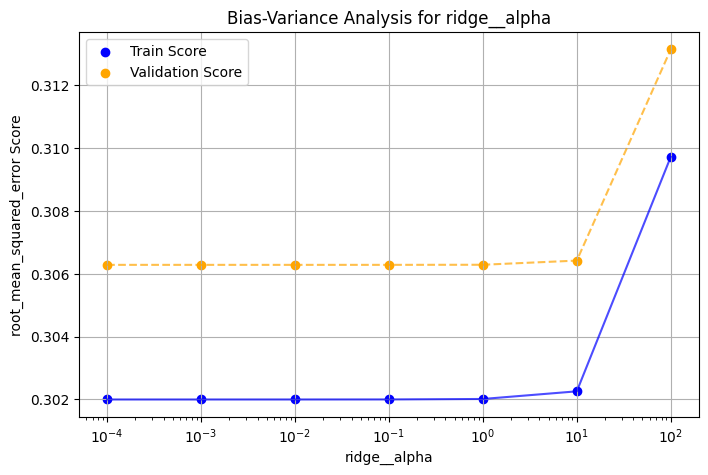


🔹 **Best Hyperparameter Configuration (Based on Validation Score)** 🔹
mean_test_score       0.313129
mean_train_score      0.309713
ridge__alpha        100.000000
variance             -0.003416


In [41]:
analyzer_ridge = BiasVarianceAnalyzer(
    search_results=grid_search_ridge,  # Results from GridSearchCV or RandomizedSearchCV
    hyperparameters=['ridge__alpha'],  # Select hyperparameters to analyze
    # scoring_metric='RMSE',  # Optional: Specify a scoring metric
    smooth_results=False # Enable smoothing to reduce zig-zag lines
  
)

# Run full bias-variance analysis
bias_variance_ridge = analyzer_ridge.analyze()

	1.	Small Alpha Values (10⁻⁴ to ~1)
	•	Both train and validation RMSE remain very low and close to each other.
	•	This suggests low regularization, meaning the model is fitting the data well without much penalty on large coefficients.
	•	However, if RMSE is too low, it may indicate overfitting (i.e., the model memorizing training data rather than generalizing).
      
	2.	Moderate Alpha Values (~1 to 10)
	•	Train RMSE slightly increases, while validation RMSE stays stable.
	•	The model begins to generalize better, as it’s not fitting training data too tightly.
	•	This is often the optimal range for Ridge regression since it balances bias and variance.
      
	3.	Large Alpha Values (10 to 100)
	•	Train RMSE increases sharply, meaning the model is struggling to fit the training data.
	•	Validation RMSE also increases significantly, which means the model’s predictive ability is declining.
	•	This suggests underfitting due to excessive regularization, where the Ridge penalty forces coefficients to shrink too much, reducing model complexity.


    This curves suggest picking an alpha of between 1-10 which shows potentially less over-fitting however the GridSearch picked 0.0001 as best Alpha because it simply takes the lowest CV score.

    **Next Steps:**
    1. Manually check the RMSE for various Alpha levels between 0.0001 and 10 and comapre loss scores

In [42]:
# ✅ Get the trained preprocessor from Grid Search pipeline
fitted_preprocessor = grid_search_ridge.best_estimator_.named_steps['preprocessor']

# ✅ Define the alphas to test (excluding the best one)
tested_alphas = [0.0001, 0.01, 0.1, 1, 10, 100]  # Adjust based on your param grid

# ✅ Dictionary to store RMSE values
test_rmse_results = {}

# ✅ Loop through each alpha and train a Ridge model
for alpha in tested_alphas:
    ridge = Ridge(alpha=alpha)  # Manually define Ridge model
    X_train_transformed = fitted_preprocessor.transform(X_train)  # Apply the same preprocessing
    X_test_transformed = fitted_preprocessor.transform(X_test)  # Apply the same preprocessing
    
    ridge.fit(X_train_transformed, y_train)  # Train model on transformed data
    
    y_pred = np.exp(ridge.predict(X_test_transformed))  # Predict on test set
    
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)  # Compute RMSE
    test_rmse_results[alpha] = test_rmse  # Store results

# ✅ Display RMSE for each tested alpha
for alpha, rmse in test_rmse_results.items():
    print(f"Alpha: {alpha}, Test RMSE: {rmse:.4f}")

Alpha: 0.0001, Test RMSE: 206562.6740
Alpha: 0.01, Test RMSE: 206562.5321
Alpha: 0.1, Test RMSE: 206561.2489
Alpha: 1, Test RMSE: 206549.1410
Alpha: 10, Test RMSE: 206495.8766
Alpha: 100, Test RMSE: 209772.8886


Not a material difference between alpha of 0.0001 (best model from GridSearch) and alpha of up to 10.  
Stick with GridSearch model for simplicity.

In [43]:
analyzer_ridge.scores

,mean_test_score,mean_train_score,ridge__alpha,variance
0,0.306280,0.301999,0.0001,-0.004281
1,0.306280,0.301999,0.0010,-0.004281
2,0.306280,0.301999,0.0100,-0.004281
3,0.306280,0.302000,0.1000,-0.004280
4,0.306283,0.302015,1.0000,-0.004268
5,0.306415,0.302258,10.0000,-0.004158
6,0.313129,0.309713,100.0000,-0.003416


In [44]:
# Extract the best pipeline from GridSearchCV
best_pipeline_ridge = grid_search_ridge.best_estimator_
best_pipeline_lasso = grid_search_lasso.best_estimator_


# Make Predictions (Transformation in pipeline will automatically be applied to test sets)
y_pred_ridge = np.exp(best_pipeline_ridge.predict(X_test))
y_pred_lasso = np.exp(best_pipeline_lasso.predict(X_test))

# Compute RMSE and R² for Ridge
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Compute RMSE and R² for Lasso
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
r2_lasso = r2_score(y_test, y_pred_lasso)

# Print results
print(f"Ridge Test RMSE: {rmse_ridge:.0f}, R²: {r2_ridge:.4f}")
print(f"Lasso Test RMSE: {rmse_lasso:.0f}, R²: {r2_lasso:.4f}")

Ridge Test RMSE: 206101, R²: 0.6711
Lasso Test RMSE: 206116, R²: 0.6710


In [45]:
model_scores['ridge'] = {
    'rmse': rmse_ridge,
    'r2': r2_ridge
}

model_scores['lasso'] = {
    'rmse':rmse_lasso,
    'r2':r2_lasso
}

### Feature Importance

In [46]:
# Extract the trained Ridge model from the pipeline
best_ridge_model = best_pipeline_ridge.named_steps['ridge']
best_lasso_model = best_pipeline_lasso.named_steps['lasso']

# Get the feature names after transformation
# First, apply preprocessing to get transformed feature names
transformed_feature_names = best_pipeline_ridge.named_steps['preprocessor'].get_feature_names_out()

# ✅ Extract the fitted preprocessor from the trained pipeline
fitted_preprocessor = best_pipeline_ridge.named_steps['preprocessor']


# ✅ Extract the scaler used for numeric features
scaler = fitted_preprocessor.named_transformers_['scaler']

average_price = data_raw['price'].mean()


feature_importance_ridge = FeatureImportanceAnalyzer(best_ridge_model, transformed_feature_names, target_transformation="log",feature_scaler=scaler, target_average = average_price)

# Extract and display feature importance
feature_importance_df_ridge = feature_importance_ridge.extract_feature_importance()

print(average_price)
print(feature_importance_df_ridge)


551962.9884732141
                    Feature   Importance  Abs_Importance
0      target_encoder__city  4411.662174     4411.662174
9        scaler__sqft_total  1651.627758     1651.627758
5               scaler__age  1085.784663     1085.784663
2         scaler__bathrooms   872.671847      872.671847
3            scaler__floors   536.274330      536.274330
1          scaler__bedrooms  -481.535315      481.535315
6         scaler__renovated   104.515881      104.515881
7  scaler__years_since_reno    60.856763       60.856763
4         scaler__condition     7.303109        7.303109
8          scaler__basement     3.039603        3.039603


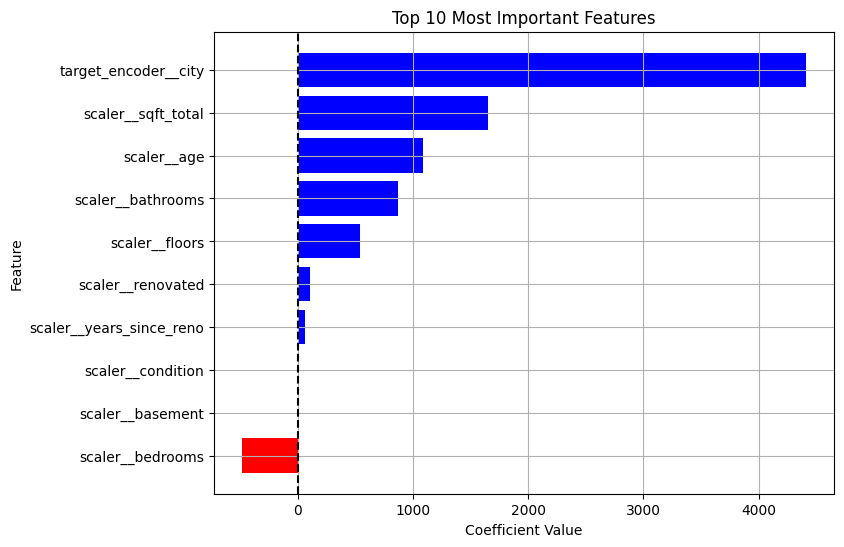

In [47]:

feature_importance_ridge.plot_feature_importance()

Observations:
1. City is the most important feature. It was target encoded so it means that cities have large difference in average house prices
2. Sqft_total is second largest
3. Interestingly, age is third largest in a positive direction, which seems counter-intuitive. See if other models show this same relationship.


In [48]:
zeroed_features = feature_importance_df_ridge[feature_importance_df_ridge['Importance'] == 0]
print("Lasso Eliminated Features:", zeroed_features)

Lasso Eliminated Features: Empty DataFrame
Columns: [Feature, Importance, Abs_Importance]
Index: []


### Check Multicollinearity  

**Rules of Thumb:**  
	•	VIF < 5 → Low multicollinearity ✅ (Good)  
  	•	VIF > 5 → Moderate multicollinearity ⚠️ (Check)  
	•	VIF > 10 → Severe multicollinearity ❌ (Remove or transform features)  

In [49]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(pipeline, X):
    """
    Computes Variance Inflation Factor (VIF) for each feature after applying preprocessing.
    
    Args:
        pipeline: Trained pipeline that includes preprocessing.
        X: Original DataFrame with raw independent variables.
    
    Returns:
        DataFrame with feature names and corresponding VIF values.
    """
    # Apply preprocessing (encoding + scaling) from the pipeline
    X_processed = pipeline.named_steps['preprocessor'].transform(X)
    
    # Get transformed feature names
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
    
    # Convert to DataFrame
    X_processed = pd.DataFrame(X_processed, columns=feature_names)
    
    # Compute VIF only for numeric features
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_processed.columns
    vif_data["VIF"] = [variance_inflation_factor(X_processed.values, i) for i in range(X_processed.shape[1])]
    
    return vif_data.sort_values(by="VIF", ascending=False)

# Example Usage
vif_df = calculate_vif(best_pipeline_ridge, X_train)  # Pass raw X_train
print(vif_df)

                    Feature       VIF
2         scaler__bathrooms  3.104603
9        scaler__sqft_total  2.935034
5               scaler__age  1.865369
3            scaler__floors  1.766628
1          scaler__bedrooms  1.754948
4         scaler__condition  1.503648
8          scaler__basement  1.373003
6         scaler__renovated  1.288415
7  scaler__years_since_reno  1.064020
0      target_encoder__city  1.000049


## 5b. Random Forest

**Scaling (StandardScaler, MinMaxScaler)**	❌ Not needed (Random Forest is not sensitive to scale)  
**Target Encoding (Zipcode, State)** ⚠️ Risky for leakage → Use One-Hot or Ordinal Encoding instead  (XGB can handle categorical features)
**Handling Missing Values (years_since_reno)**	✅ Median imputation is fine; consider adding a missing indicator  
**Log Transforming Skewed Features**	✅ Keep log-transformed features if they improved performance  

In [50]:

# ✅ Define RandomForest pipeline (Fix: Name step correctly)
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=32))
])

# ✅ Define hyperparameters (Fix: Prefix with 'rf__')
rf_params_random = {
    'rf__n_estimators': [50, 100, 200, 500],  # Number of trees in the forest; more trees improve stability but increase training time.
    'rf__max_depth': [2, 5, 10, None],  # Maximum depth of trees; deeper trees capture more patterns but may overfit.
    'rf__min_samples_split': [2, 5, 10],  # Min samples needed to split a node; higher values reduce overfitting.
    'rf__min_samples_leaf': [1, 5, 10],  # Min samples required at a leaf; larger values force the model to generalize more.
    'rf__bootstrap': [True, False]  # Whether to sample data with replacement; `True` adds randomness, reducing overfitting.
}

# ✅ Random Search Cross Validation (Fix: Correct param_grid prefixes)
rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_params_random,
    n_iter=20,  # Number of random samples
    scoring='neg_root_mean_squared_error',
    cv=3,  # 3-Fold CV
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    return_train_score=True
)

# ✅ Fit the model
rf_random_search.fit(X_train, y_train)

# ✅ Print Best Parameters & RMSE
print(f"Best RMSE: {-rf_random_search.best_score_:.4f}")
print(f"Best Parameters: {rf_random_search.best_params_}")

Best RMSE: 0.3434
Best Parameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_depth': 5, 'rf__bootstrap': True}


In [51]:
scores_random_rf = extract_results(rf_random_search, rf_params_random)

Best score: 0.3434
Best parameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_depth': 5, 'rf__bootstrap': True}
   mean_test_score  mean_train_score param_rf__n_estimators  \
0        -0.343450         -0.318597                    100   
1        -0.388757         -0.382821                    100   
2        -0.405790         -0.342582                     50   
3        -0.344154         -0.316363                    200   
4        -0.373555         -0.343151                    100   
5        -0.374798         -0.368619                    100   
6        -0.344060         -0.318171                    200   
7        -0.388757         -0.382821                     50   
8        -0.359828         -0.312596                    100   
9        -0.375195         -0.346341                    500   

  param_rf__max_depth param_rf__min_samples_split param_rf__min_samples_leaf  \
0                   5                          10                

In [52]:
# Example Usage with RandomForest
rf_random_analyzer= BiasVarianceAnalyzer(
    search_results=rf_random_search,  # Results from GridSearchCV or RandomizedSearchCV
    hyperparameters=['rf__max_depth', 'rf__n_estimators','rf__min_samples_split'],  # Select hyperparameters to analyze
    scoring_metric='neg_root_mean_squared_error',  # Optional: Specify a scoring metric
    smooth_results=True # Enable smoothing to reduce zig-zag lines

)

rf_random_bias_variance = rf_random_analyzer.analyze()




🔹 **Best Hyperparameter Configuration (Based on Validation Score)** 🔹
rf__max_depth            10.000000
rf__n_estimators         50.000000
rf__min_samples_split     2.000000
mean_test_score           0.398684
mean_train_score          0.335601
variance                 -0.063083


errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


In [53]:
rf_search_best = rf_random_search.best_estimator_

y_pred_rf_search = np.exp(rf_search_best.predict(X_test))

rmse_rf_search = mean_squared_error(y_test, y_pred_rf_search, squared=False)
r2_rf_search = r2_score(y_test, y_pred_rf_search)

print("rmse_rf_search:", rmse_rf_search)
print("r2_rf_search:", r2_rf_search)


model_scores['random_forest_search'] = {
    'rmse': rmse_rf_search,
    'r2': r2_rf_search
}

rmse_rf_search: 227130.68728070808
r2_rf_search: 0.6005200599597922


In [54]:
# Optimize Hyperparameters with Optuna (Bayesian Optimization technique)

# ✅ Define pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=32))
])

# ✅ Define the Optuna objective function
def objective(trial):
    params = {
        'rf__n_estimators': trial.suggest_int('rf__n_estimators', 50, 500, log=True),
        'rf__max_depth': trial.suggest_categorical('rf__max_depth', [2, 5, 10, None]),
        'rf__min_samples_split': trial.suggest_int('rf__min_samples_split', 2, 10, log=True),
        'rf__min_samples_leaf': trial.suggest_int('rf__min_samples_leaf', 1, 10, log=True),
        'rf__bootstrap': trial.suggest_categorical('rf__bootstrap', [True, False])
    }

    rf_pipeline.set_params(**params)
    score = cross_val_score(rf_pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1).mean()
    return score  # Maximizing negative MSE

# ✅ Increase trials to improve Optuna's search
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Increased from 20 to 100

# ✅ Print Best Results
best_optuna_rmse = np.exp(((-study.best_value)))
print(f"Best RMSE (Optuna): {best_optuna_rmse:.4f}")
print(f"Best Hyperparameters: {study.best_params}")

# ✅ Train final model with best parameters
best_rf_pipeline = rf_pipeline.set_params(**study.best_params)
best_rf_model = best_rf_pipeline.fit(X_train, y_train)



[I 2025-03-18 01:12:38,494] A new study created in memory with name: no-name-75d7135a-906b-4356-b8ca-aba251ac00b0
[I 2025-03-18 01:12:39,073] Trial 0 finished with value: -0.3735554315595664 and parameters: {'rf__n_estimators': 83, 'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__bootstrap': False}. Best is trial 0 with value: -0.3735554315595664.
[I 2025-03-18 01:12:39,801] Trial 1 finished with value: -0.36113032223653324 and parameters: {'rf__n_estimators': 71, 'rf__max_depth': None, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__bootstrap': True}. Best is trial 1 with value: -0.36113032223653324.
[I 2025-03-18 01:12:40,305] Trial 2 finished with value: -0.3609337166818766 and parameters: {'rf__n_estimators': 59, 'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 7, 'rf__bootstrap': True}. Best is trial 2 with value: -0.3609337166818766.
[I 2025-03-18 01:12:41,074] Trial 3 finished with value: -0.37355543155956755 an

Best RMSE (Optuna): 1.4097
Best Hyperparameters: {'rf__n_estimators': 293, 'rf__max_depth': 5, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 4, 'rf__bootstrap': True}


In [55]:
# Evaluate final on test set

y_pred_rf_optuna = np.exp(best_rf_pipeline.predict(X_test))

rmse_rf_optuna = mean_squared_error(y_test,y_pred_rf_optuna, squared=False)
r2_rf_optuna = r2_score(y_test,y_pred_rf_optuna)

print("rmse_rf:", rmse_rf_optuna)
print("r2_rf:", r2_rf_optuna)

model_scores['random_forest_optuna'] = {
    'rmse': rmse_rf_optuna,
    'r2': r2_rf_optuna
}



rmse_rf: 229634.8987939247
r2_rf: 0.5916626299475943


## 5c. XGBoost

Pre-processing
1. Encoding - No
2. Imputing - Yes
3. Scaling - No

Pre-proessing was already done in previous steps

In [56]:
# Define Pipeline
# Not necessary since no pre-processing

In [57]:
xgb_param_grid = {
    # **1️⃣ Most Important (Must Have)**
    'n_estimators': [500, 1000, 2000],  # Number of boosting rounds
    'learning_rate': [0.005, 0.01, 0.05],  # Step size shrinkage
    'max_depth': [3, 4, 5, 6, 7],  # Depth of each tree

    # **2️⃣ Second Most Important (Highly Recommended)**
    'subsample': [0.7, 0.8, 0.9],   # % of rows used per tree
    'colsample_bytree': [0.7, 0.8, 0.9],   # % of features used per tree
    'gamma': [0, 0.1, 0.5, 1],  # Minimum loss reduction for split (regularization)

    # **3️⃣ Regularization (Only If Overfitting)**
    'reg_alpha': [0, 0.1, 1, 10],  # L1 Regularization
    'reg_lambda': [1, 5, 10, 50],  # L2 Regularization

    # **4️⃣ Advanced Tweaks (Rarely Needed)**
    # 'min_child_weight': [1, 5, 10],  # Minimum sum of instance weight per leaf
    # 'colsample_bylevel': [0.6, 0.8, 1.0],  # % of features per tree level
    # 'scale_pos_weight': [1]  # Used for imbalanced classification (ignored in regression)
}

# XGB may work better with non-log-transformed Y variable
y_train_exp = np.exp(y_train)

# Create a copy of X_train
X_train_exp = X_train.copy()
X_test_exp = X_test.copy()

# Reverse the log transformation for specified variables
log_variables = [
    'price',
    'sqft_living',
    'sqft_lot',
    'sqft_total',
    'years_since_reno'
]

for var in log_variables:
    if var in X_train_exp.columns:
        X_train_exp[var] = np.exp(X_train_exp[var])
    if var in X_test_exp.columns:
        X_test_exp[var] = np.exp(X_test_exp[var])


encoder = LeaveOneOutEncoder(cols=["city"])
X_train_exp["city"] = encoder.fit_transform(X_train_exp["city"], y_train_exp)
X_test_exp["city"] = encoder.transform(X_test_exp["city"])

In [58]:
# Convert categorical column to category type
X_train_exp["city"] = X_train_exp["city"].astype("category")
X_test_exp["city"] = X_test_exp["city"].astype("category")  # Also do this for test set



# Random Search Cross Validation

xgb_random_search = RandomizedSearchCV(
    XGBRegressor(enable_categorical=True),
    param_distributions = xgb_param_grid,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# Fit model
xgb_random_search.fit(X_train_exp, y_train_exp)

# ✅ Print Best Parameters & RMSE
print(f"Best RMSE: {-xgb_random_search.best_score_:.4f}")
print(f"Best Parameters: {xgb_random_search.best_params_}")

Best RMSE: 519986.2119
Best Parameters: {'subsample': 0.9, 'reg_lambda': 50, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.7}


In [59]:
xgb_bias_variance = BiasVarianceAnalyzer(xgb_random_search, smooth_results=True, hyperparameters=['n_estimators','learning_rate'])
xgb_bias_variance.plot_bias_variance()
xgb_bias_variance.analyze()



🔹 **Best Hyperparameter Configuration (Based on Validation Score)** 🔹
n_estimators          2000.000000
learning_rate            0.050000
mean_test_score     714772.887469
mean_train_score     12935.215095
variance           -701837.672375


errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead


,n_estimators,learning_rate,mean_test_score,mean_train_score,variance
0,500,0.005,555323.057844,364082.087343,-191240.970501
1,500,0.010,583569.935904,259490.641053,-324079.294851
2,500,0.050,650969.382472,48205.305582,-602764.076890
3,1000,0.005,580361.495236,226005.500455,-354355.994781
4,1000,0.010,625575.091810,51571.740093,-574003.351717
5,1000,0.050,688005.086202,28913.192133,-659091.894069
6,2000,0.005,562136.055871,314454.226746,-247681.829124
7,2000,0.010,637558.613669,110931.209937,-526627.403732
8,2000,0.050,714772.887469,12935.215095,-701837.672375


In [60]:
# Extract best XGB model
xgb_best_model = xgb_random_search.best_estimator_


# predict on test set
y_pred_xgb = xgb_best_model.predict(X_test_exp)

# Evaluate on RMSE and R^2
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Print results
print("rmse_xgb:", rmse_xgb)

print("r2_xgb:", r2_xgb)

rmse_xgb: 283401.70405864983
r2_xgb: 0.37806032770949205


In [61]:
model_scores['xgb'] = {
    'rmse': rmse_xgb,
    'r2': r2_xgb
}


### Feature Importance

**F-score** measures how many times a feature was used in a decision tree split across all trees in the boosted ensemble.  
Higher F-score means more important


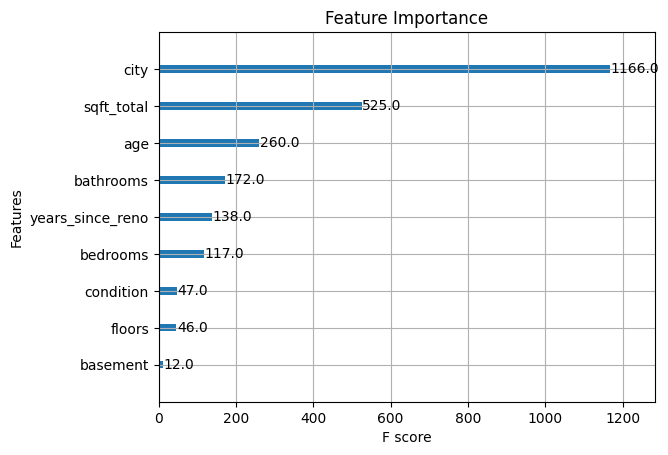

In [62]:
# Feature Importance

plot_importance(xgb_best_model)
plt.title('Feature Importance')
plt.show()


Observations:
- Similar to feature importance from Linear Regression model, the 3 most important features are city, sqft_total, and age

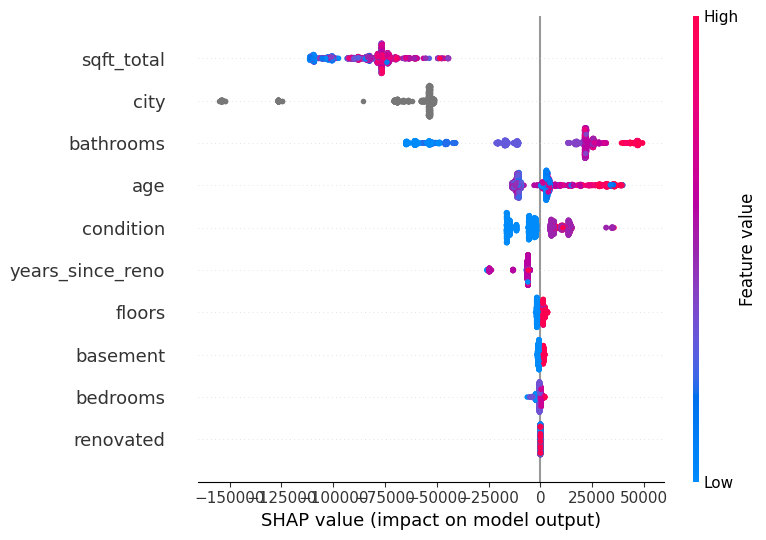

In [67]:
# Ensure categorical columns are properly encoded
X_test["city"] = X_test["city"].astype("category")

# ✅ Initialize SHAP explainer
explainer_random_xgb = shap.Explainer(xgb_best_model)

# ✅ Compute SHAP values
shap_values_random_xgb = explainer_random_xgb(X_test)

# ✅ Visualize SHAP summary plot
shap.summary_plot(shap_values_random_xgb, X_test)

-  Sqft_total has the most feature impact
-  Larger sqft_total correlates to higher house price
-  City is second most important feature. Is grey because is not a a numerical feature, but you can see that it has a wide spread, and therefore means that it influences house price significantly
- 


In [ ]:
model_scores

In [ ]:
def plot_model_performance(model_scores):
    models = list(model_scores.keys())
    rmse_values = [model_scores[m]['rmse'] for m in models]
    r2_values = [model_scores[m]['r2'] for m in models]
    
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    # Bar chart for RMSE
    ax1.bar(models, rmse_values, color='blue', alpha=0.7, label='RMSE')
    ax1.set_xlabel("Models")
    ax1.set_ylabel("RMSE (Lower is better)", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Line chart for R2 score
    ax2 = ax1.twinx()
    ax2.plot(models, r2_values, color='red', marker='o', linestyle='dashed', label='R² Score')
    ax2.set_ylabel("R² Score (Higher is better)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.title("Model Performance: RMSE vs R² Score")
    fig.tight_layout()
    plt.show()
    
# Example usage:
model_scores = {
    'ridge': {'rmse': 206101.15468640783, 'r2': 0.6710694616886103},
    'lasso': {'rmse': 206115.65135993686, 'r2': 0.6710231876506614},
    'random_forest_search': {'rmse': 227130.68728070808, 'r2': 0.6005200599597922},
    'random_forest_optuna': {'rmse': 233816.57216442723, 'r2': 0.5766554974129242},
    'xgb': {'rmse': 311033.59335590055, 'r2': 0.25086870267270256}
}

plot_model_performance(model_scores)